In [2]:
import sys
import os.path
sys.path.insert(1, '../FrenetSerretMeanShape')
from frenet_path import *
from trajectory import *
from model_curvatures import *
from estimation_algo_utils import *
from maths_utils import *
from simu_utils import *
from visu_utils import *
from pre_process_Mocaplab_data import take_numpy_subset, barycenter_from_3ptsHand
import numpy as np
from pickle import *
import dill as pickle
import pandas as pd
from scipy.interpolate import interp1d

INFO: Using numpy backend


In [28]:
filename = "dic_words_LSFtraj"
fil = open(filename,"rb")
dic = pickle.load(fil)
fil.close()
Data = dic["data"]
Glose = dic["glose"]

plot_3D_means([Data[0], Data[1], Data[2], Data[3]], [], "", "")
print(Glose[0], Glose[1], Glose[2], Glose[3])

Turquie territoire ville dactylologie


In [33]:
L = []
for i in range(len(Glose)):
    L.append(Data[i].shape[0])
print(np.mean(L), np.std(L))
print(np.min(L), np.max(L))
print(np.median(L))

38.55590386624869 48.45789368018076
3 451
25.0


In [5]:
path_dir = r"/home/pchassat/Documents/data/LSFtraj/"
files = os.listdir(path_dir)
N = len(files)

In [6]:
path = r"/home/pchassat/Documents/data/ROSETTA_T01_Annotations.csv"
csvFile = pd.read_csv(path, sep=',')

In [7]:
filenames = csvFile['filename'].unique()
bornes_array = np.empty((len(filenames)), dtype=object)
glose_array = np.empty((len(filenames)), dtype=object)
for i in range(len(filenames)):
    subdf = csvFile[csvFile['filename']==filenames[i]]
    bornes_array[i] = list(map(list, subdf[['start', 'end']].to_numpy()))
    glose_array[i] = list(subdf['IdGlose'])

In [16]:
print(np.array(bornes_array[0])/0.01)

[[152. 172.]
 [196. 268.]]


In [9]:
print(files)

['RO1_X0024.Titre1.csv', 'RO1_X0091.Titre1.csv', 'RO1_X0097.Titre2.csv', 'RO1_X0069.Titre4.csv', 'RO1_X0066.Titre2.csv', 'RO1_X0020.Titre2.csv', 'RO1_X0100.Titre1.csv', 'RO1_X0068.Titre2.csv', 'RO1_X0067.Titre1.csv', 'RO1_X0023.Titre3.csv', 'RO1_X0064.Titre2.csv', 'RO1_X0105.Titre2.csv', 'RO1_X0069.Titre1.csv', 'RO1_X0087.Titre1.csv', 'RO1_X0088.Titre2.csv', 'RO1_X0094.Titre3.csv', 'RO1_X0108.Titre2.csv', 'RO1_X0063.Titre1.csv', 'RO1_X0104.Titre3.csv', 'RO1_X0105.Titre1.csv', 'RO1_X0069.Titre6.csv', 'RO1_X0066.Titre3.csv', 'RO1_X0089.Titre2.csv', 'RO1_X0024.Titre3.csv', 'RO1_X0023.Titre1.csv', 'RO1_X0071.Titre1.csv', 'RO1_X0024.Titre2.csv', 'RO1_X0066.Titre1.csv', 'RO1_X0064.Titre3.csv', 'RO1_X0068.Titre1.csv', 'RO1_X0068.Titre3.csv', 'RO1_X0020.Titre1.csv', 'RO1_X0023.Titre2.csv', 'RO1_X0092.Titre1.csv', 'RO1_X0088.Titre1.csv', 'RO1_X0069.Titre5.csv', 'RO1_X0104.Titre2.csv', 'RO1_X0098.Titre1.csv', 'RO1_X0069.Titre3.csv', 'RO1_X0073.Titre1.csv', 'RO1_X0097.Titre1.csv', 'RO1_X0089.Titr

In [4]:
j = np.linspace(0, 0.01*10, 11)
print(j/0.01)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [24]:
Data = []
Glose = []
for i in range(N):
    hand_barycentre = barycenter_from_3ptsHand(path_dir+files[i], plot=False)
    data_traj = take_numpy_subset(hand_barycentre, 0, len(hand_barycentre.index))
    t = np.linspace(0,0.01*len(data_traj)-1,len(data_traj))
    ind = np.where(filenames==files[i][:-4])[0][0]
    bornes_i = np.array(bornes_array[ind])/0.01
    for j in range(len(bornes_i)):
        Data.append(data_traj[int(bornes_i[j][0]):int(bornes_i[j][1]),:])
        Glose.append(glose_array[ind][j])
    
print(len(Glose))

957


In [25]:
dic_words_LSFtraj = {"data" : Data, "glose" : Glose}

In [26]:
filename = "dic_words_LSFtraj"
if os.path.isfile(filename):
    print("Le fichier ", filename, " existe déjà.")
fil = open(filename,"xb")
pickle.dump(dic_words_LSFtraj,fil)
fil.close()

In [10]:
for i in range(N):
    print(files[i])
    hand_barycentre = barycenter_from_3ptsHand(path_dir+files[i], plot=False)
    data_traj = take_numpy_subset(hand_barycentre, 0, len(hand_barycentre.index))
    t = np.linspace(0,1,len(data_traj))
    X = Trajectory(data_traj, t)
    X.loc_poly_estimation(X.t, 5, 0.01)
    X.compute_S(scale=True)
    # t_new = np.linspace(0,1,3000)
    Q_GS = X.TNB_GramSchmidt(t)

    # Estimate raw curvature and torsion
    h = 0.002
    Q_GS.compute_neighbors(h)
    mKappa, mTau, mS, mOmega, gam, ind_conv = compute_raw_curvatures(Q_GS, h, Q_GS, False)
    print(len(mS))
    print(np.max(mKappa))
    # t_new = np.linspace(0,1,3000)
    # invS = interp1d(X.S(t_new), t_new)
    # mt = invS(mS/mS[-1])
    # s = interp1d(t, X.S(t))
    
    # ind = np.where(filenames==files[i][:-4])
    # print(ind)
    # bornes_i = np.array(bornes_array[ind][0])/((len(data_traj)-1)*0.01)
    # bornes_s = s(bornes_i)

    # layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
    # fig = go.Figure(layout=layout)
    # # fig.add_trace(go.Scatter(x=mS, y=X.Sdot(mt), mode='lines', line=dict(width=2)))
    # fig.add_trace(go.Scatter(x=mt, y=mKappa, mode='lines', line=dict(width=2)))
    # # fig.add_trace(go.Scatter(x=mt, y=mTau, mode='lines', line=dict(width=2)))
    # fig.update_xaxes(showline=True, showgrid=False, linewidth=1, linecolor='black')
    # fig.update_yaxes(showline=True, showgrid=False, linewidth=1, linecolor='black')
    # for i in range(len(np.concatenate(bornes_i))):
    #     fig.add_vline(x=np.concatenate(bornes_i)[i], line_width=2, line_dash="dash")
    # fig.show()



RO1_X0020.Titre2.csv
(array([38]),)


In [23]:
glose_array[38]

['entreprise',
 'nom',
 'dactylologie',
 'personnes',
 'zone',
 'salaire',
 'tribunal',
 'résultat',
 'attendre']

In [3]:
filename = "LSFtraj_data_preprocess"
fil = open(filename,"rb")
dic = pickle.load(fil)
fil.close()

array_X = dic["array_X"] 
array_Q_GS = dic["array_Q_GS"]

In [4]:
print(len(array_X.data))

53


In [5]:
for i in range(N):
    print(array_X[i].data.shape[0])

2498
2066
1354
1882
1658
1134
1086
1095
1827
1438
1656
1490
1088
1243
1971
1735
2173
1130
1643
1435
1004
1617
1887
1270
1352
1384
1654
1815
864
1233
1107
1428
1294
1552
1756
832
1117
1008
938
1740
876
1856
1107
1913
1510
1764
1692
892
1125
2158
940
2276
1196


In [7]:
param_bayopt = {"n_splits":  10, "n_calls" : 5, "bounds_h" : (0.001, 0.004), "bounds_lcurv" : (1e-15, 1e-14), "bounds_ltors" :  (1e-12, 1e-10)}
param_model = {"nb_basis" : 1000, "domain_range": (0.02, 0.98)}

print("Individual estimations...")

array_SmoothFP = np.empty((N), dtype=object)
array_resOpt = np.empty((N), dtype=object)
array_SmoothThetaFP = np.empty((N), dtype=object)

Individual estimations...


Iteration No: 1 started. Evaluating function at random point.
[0.003991554432816607, 9.39301623404793e-15, 1.368432034500632e-11]


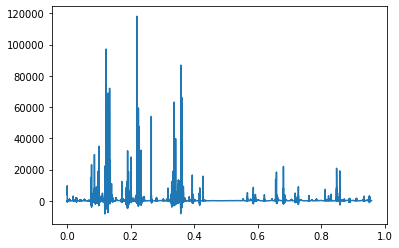

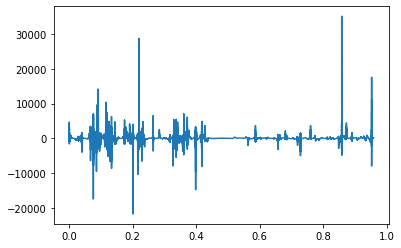

KeyboardInterrupt: 

In [8]:
for i in range(N):
    array_SmoothFP[i], array_resOpt[i] = global_estimation(array_Q_GS[i], param_model, opt=True, param_bayopt=param_bayopt)